# Tacotron Training Notebook



# Check GPU

First, if you want, you can check to see which GPU is currently being used. The best GPUs are P100, V100, and T4. If you get a K80 or P4, you can restart the runtime and try again if you'd like, but all GPUs will (probably) work with this notebook.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-585651cf-1d35-9dc6-f517-d8ca675bc6cb)


In [13]:
import wandb
wandb.init(project="tacotron_sansone_en_finetuningmov", entity="ciro97sa")

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Prepare the model

This next section prepares the model and stuff for training.


In [3]:
#@title A bunch of boring code and stuff (if you want to look at it, double click on this cell)
%matplotlib inline
import os
import time
import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams
 
import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
#from tqdm import tqdm # Terminal
#from tqdm import tqdm_notebook as tqdm # Legacy Notebook TQDM
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename, 
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))
    try:
        torch.save({'iteration': iteration,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("interrupt received while saving, waiting for save to complete.")
        torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        wandb.log({"val_loss": val_loss, "y": y, "y_pred": y_pred, "iteration": iteration})
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      os.path.isfile("pretrained_model")
      download_from_google_drive("1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA","pretrained_model")
      model = warm_start_model("pretrained_model", model, hparams.ignore_layers)
      # download LJSpeech pretrained model if no checkpoint already exists
    
    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start

                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                wandb.log({"train_loss": reduced_loss, "grad_norm": grad_norm, "duration": duration, "iteration": iteration})    
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
# ---- Replace .wav with .npy in filelists ----

warm_start=False#sorry bout that
n_gpus=1
rank=0
group_name=None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
model_filename = 'sansone'
hparams.training_files = "filelists/filelists.txt"
hparams.validation_files = "filelists/filelists.txt"
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory' # Location to save Checkpoints
log_directory = '/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/logs' # Location to save Log files locally
log_directory2 = '/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

This is where you put the name of the model (usually the name of the person's voice you're cloning)

In [4]:
#@title Name the model

model_filename = "sansone_en_final" #@param {type:"string"}

Replace "PUTFILENAMEHERE" with the name of your text file.

In [5]:
hparams.training_files = "/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/filelists/filelists.txt"
hparams.validation_files = "/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/filelists/filelists.txt"

### Set the parameters

You can play around with these if you want.

In [18]:
# hparams to Tune

#These two are the most important
hparams.batch_size = 32 # Controls how fast the model trains. Don't set this too high, or else it will GPU will OOM (out of memory). 30-ish is usually a good number if you have a bigger dataset. If the number of audio files is more than/about the same as this number, it won't train properly, and you won't be able to use it.
hparams.epochs = 1000 # Maxmimum epochs (number of times the AI looks through the dataset) to train

#The rest aren't that important
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000         # wait till decay_start to start decaying learning rate
hparams.A_ = 5e-4                   # Start/Max Learning Rate
hparams.B_ = 8000                   # Decay Rate
hparams.C_ = 0                      # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-5    # Min Learning Rate
generate_mels = True # Don't change
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.load_mel_from_disk = True
hparams.ignore_layers = [] # Layers to reset (None by default, other than foreign languages this param can be ignored)

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory' # Location to save Checkpoints
log_directory = '/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/logs' # Location to save Log files locally
log_directory2 = '/home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/logs2' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

### Create MEL spectrograms

The MEL spectrograms are the input for the AI.

In [19]:
if generate_mels:
    create_mels()

Generating Mels


  0%|          | 0/275 [00:00<?, ?it/s]

### Check data

This cell will go through the dataset one more time to see if anything's wrong before training starts.

In [20]:
check_dataset(hparams)

Checking Training Files
Checking Validation Files
Finished Checking


In [21]:
wandb.config = {
  "learning_rate": hparams.min_learning_rate,
  "epochs": hparams.epochs,
  "batch_size": hparams.batch_size
}

# Start training!

This next cell will begin training the model!

FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    815      0 --:--:-- --:--:-- --:--:--   817
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  107M  100  107M    0     0  42.6M      0  0:00:02  0:00:02 --:--:--  128M
Warm starting model from checkpoint 'pretrained_model'


  0%|          | 0/1000 [00:00<?, ?it/s]


Starting Epoch: 0 Iteration: 0


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0 Validation loss 8:  0.392221  Time: 0.4m LR: 0.000500


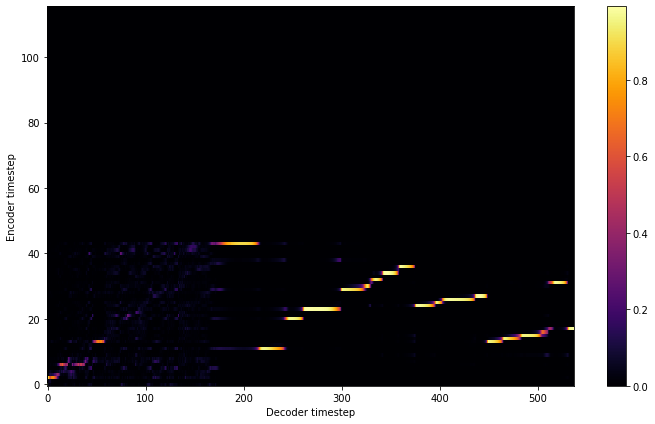

Saving model and optimizer state at iteration 8 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 1 Iteration: 8


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 Validation loss 16:  0.344817  Time: 0.4m LR: 0.000500


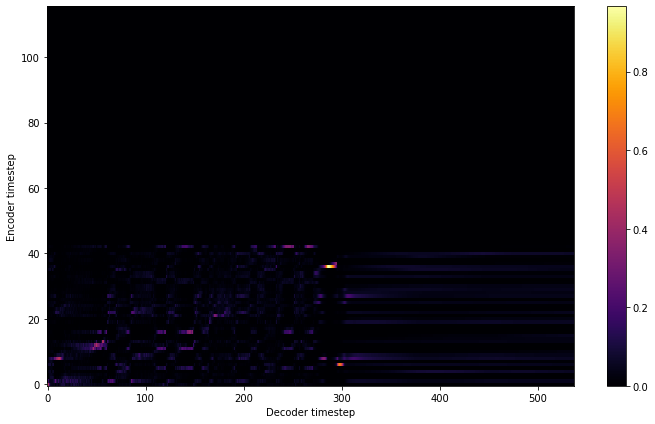

Saving model and optimizer state at iteration 16 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 2 Iteration: 16


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2 Validation loss 24:  0.321282  Time: 0.4m LR: 0.000500


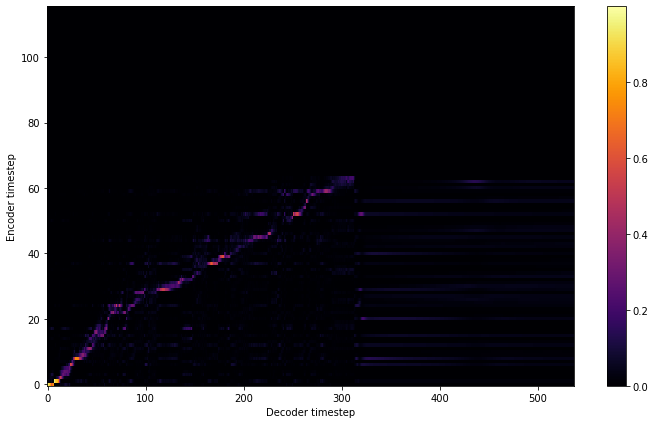

Saving model and optimizer state at iteration 24 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 3 Iteration: 24


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3 Validation loss 32:  0.309485  Time: 0.4m LR: 0.000500


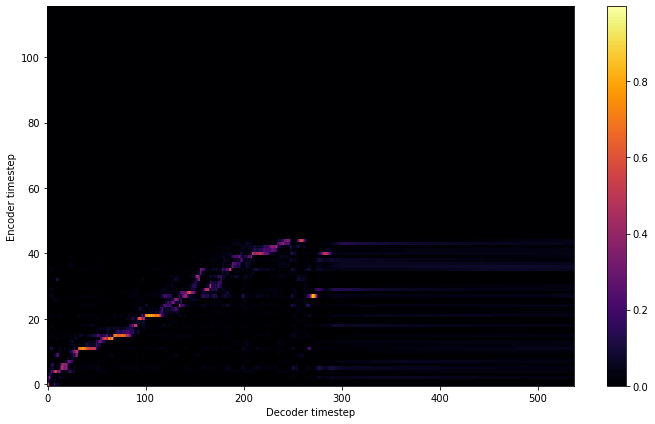

Saving model and optimizer state at iteration 32 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 4 Iteration: 32


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4 Validation loss 40:  0.288873  Time: 0.4m LR: 0.000500


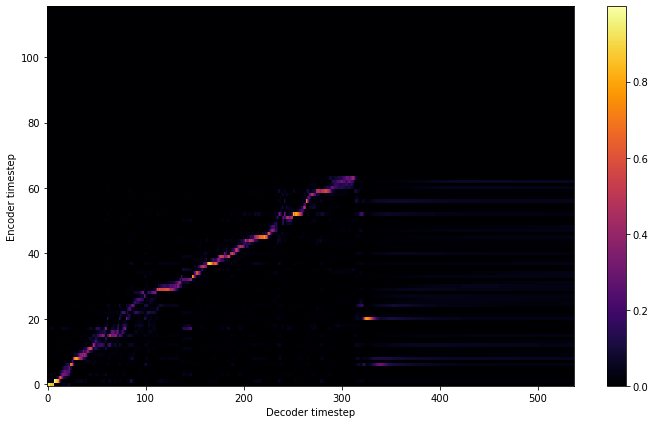

Saving model and optimizer state at iteration 40 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 5 Iteration: 40


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5 Validation loss 48:  0.278550  Time: 0.4m LR: 0.000500


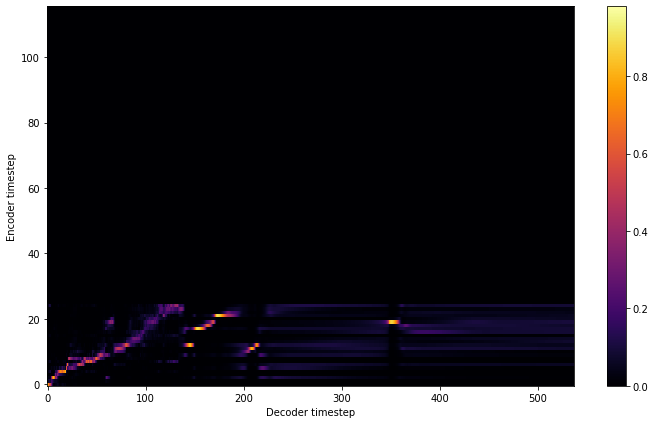

Saving model and optimizer state at iteration 48 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 6 Iteration: 48


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6 Validation loss 56:  0.271921  Time: 0.4m LR: 0.000500


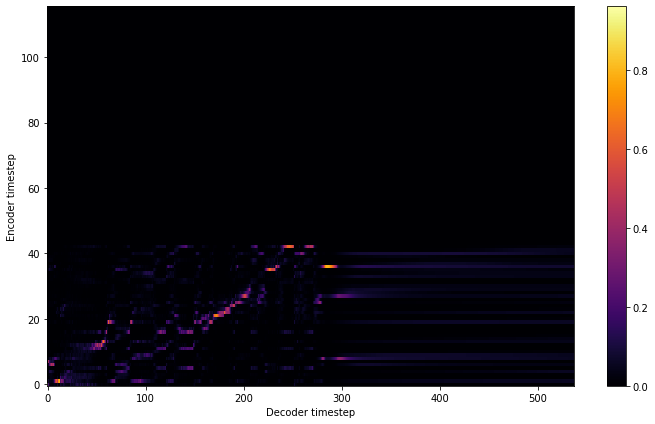

Saving model and optimizer state at iteration 56 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 7 Iteration: 56


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7 Validation loss 64:  0.266216  Time: 0.4m LR: 0.000500


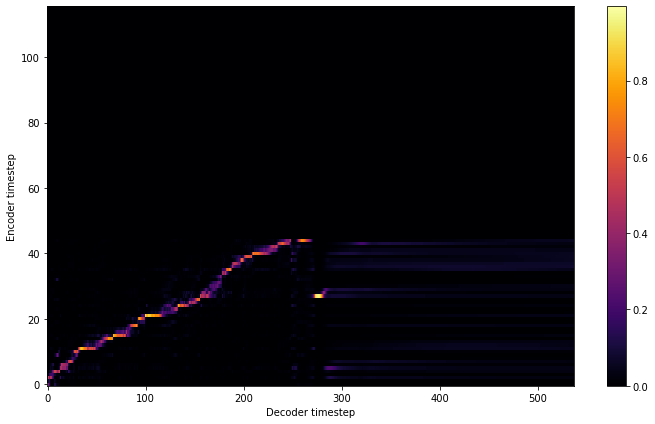

Saving model and optimizer state at iteration 64 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 8 Iteration: 64


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8 Validation loss 72:  0.261686  Time: 0.4m LR: 0.000500


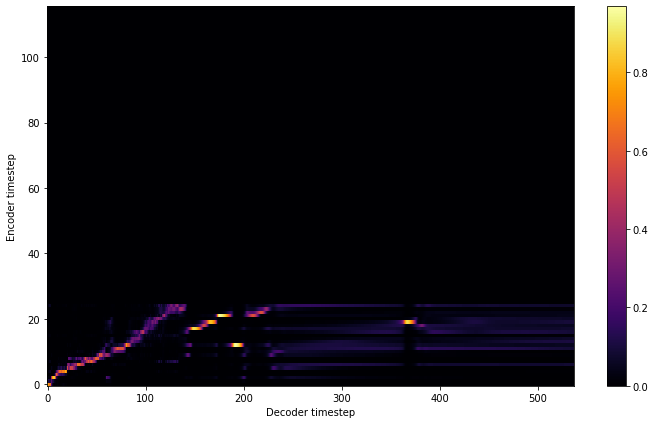

Saving model and optimizer state at iteration 72 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 9 Iteration: 72


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9 Validation loss 80:  0.251573  Time: 0.4m LR: 0.000500


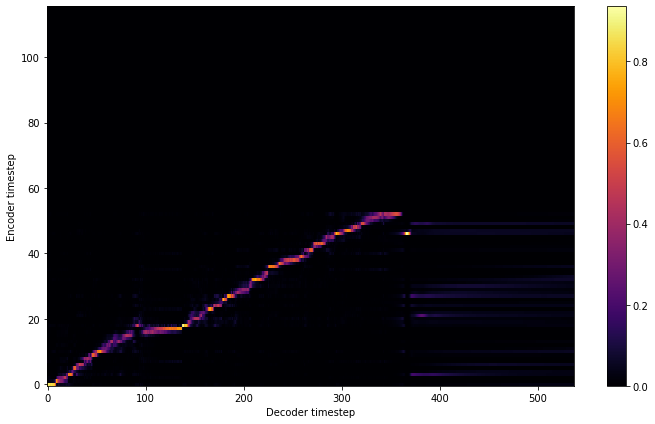

Saving model and optimizer state at iteration 80 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 10 Iteration: 80


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10 Validation loss 88:  0.244780  Time: 0.4m LR: 0.000500


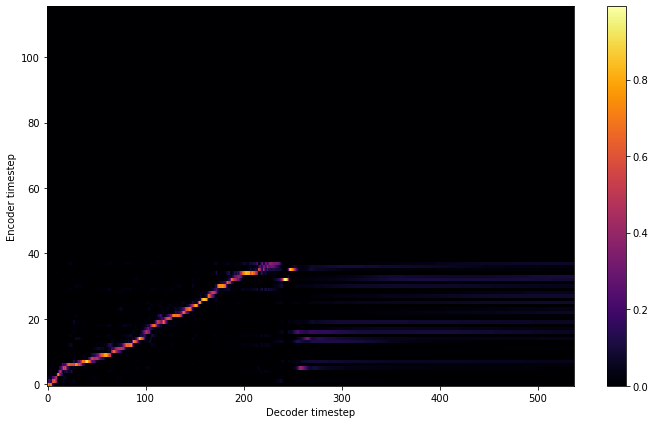

Saving model and optimizer state at iteration 88 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 11 Iteration: 88


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11 Validation loss 96:  0.240262  Time: 0.4m LR: 0.000500


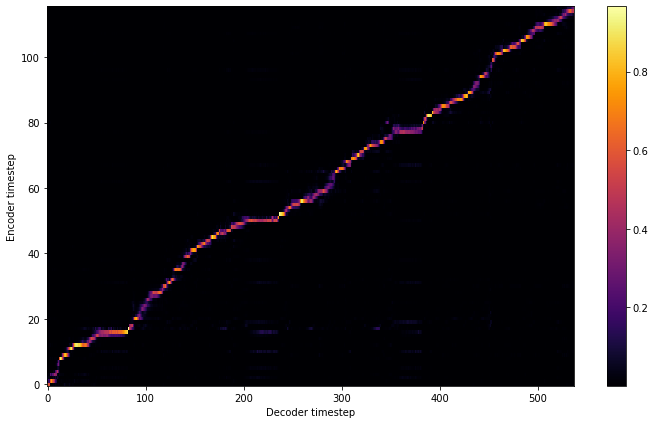

Saving model and optimizer state at iteration 96 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 12 Iteration: 96


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12 Validation loss 104:  0.234170  Time: 0.4m LR: 0.000500


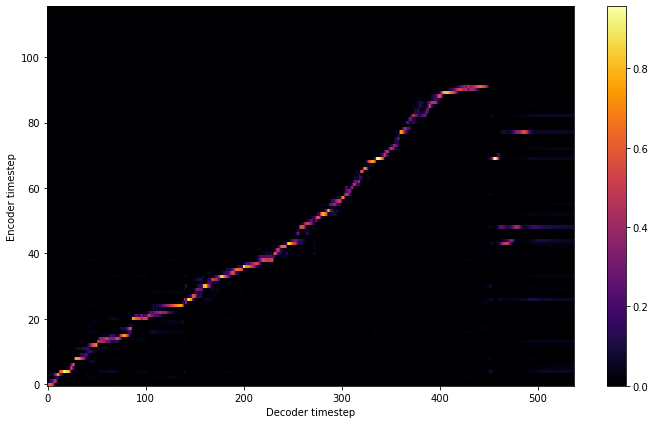

Saving model and optimizer state at iteration 104 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 13 Iteration: 104


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13 Validation loss 112:  0.236163  Time: 0.4m LR: 0.000500


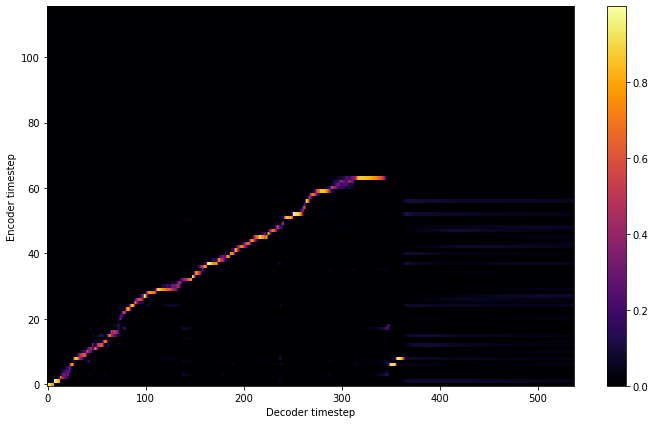

Saving model and optimizer state at iteration 112 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 14 Iteration: 112


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14 Validation loss 120:  0.236439  Time: 0.4m LR: 0.000500


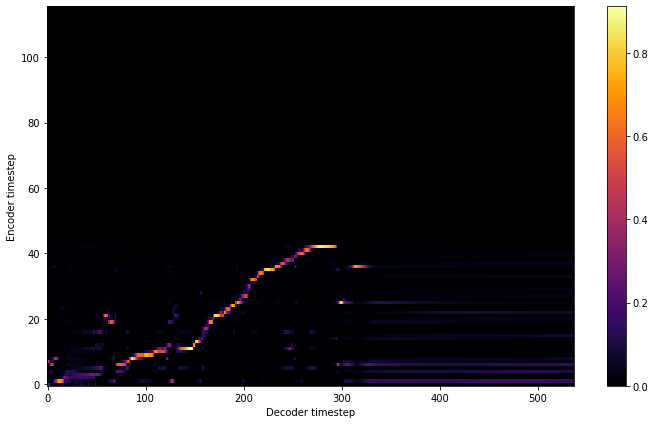

Saving model and optimizer state at iteration 120 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 15 Iteration: 120


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15 Validation loss 128:  0.227700  Time: 0.4m LR: 0.000500


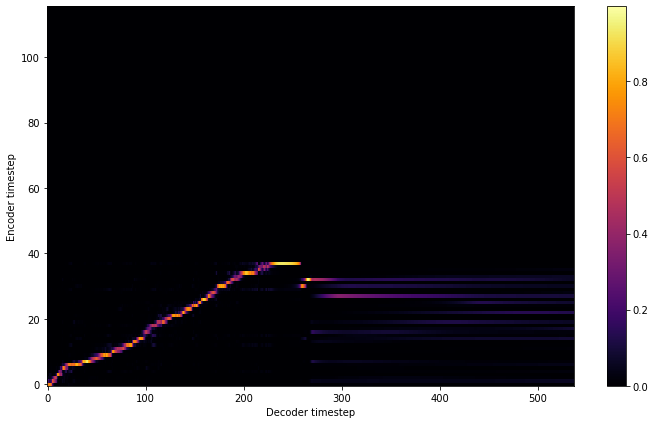

Saving model and optimizer state at iteration 128 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 16 Iteration: 128


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16 Validation loss 136:  0.227299  Time: 0.4m LR: 0.000500


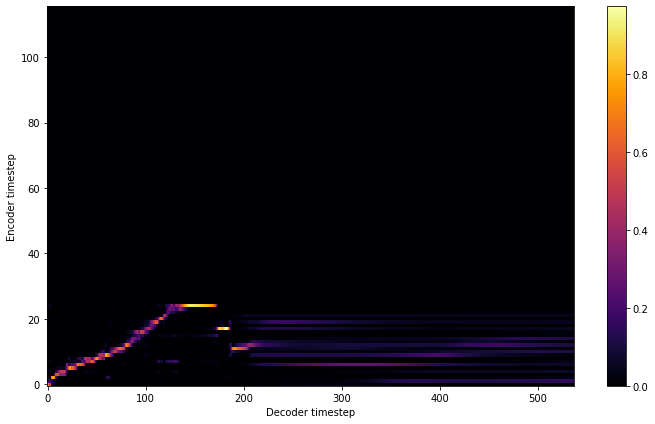

Saving model and optimizer state at iteration 136 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 17 Iteration: 136


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17 Validation loss 144:  0.227093  Time: 0.4m LR: 0.000500


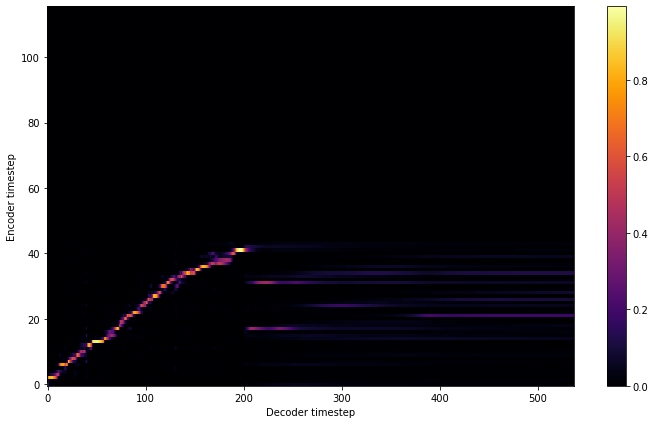

Saving model and optimizer state at iteration 144 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 18 Iteration: 144


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18 Validation loss 152:  0.220375  Time: 0.4m LR: 0.000500


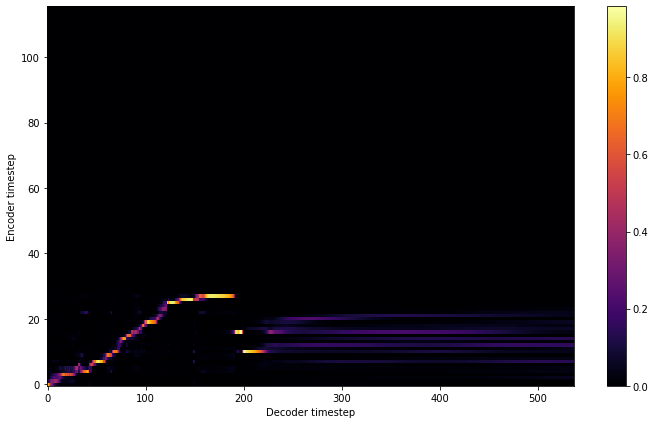

Saving model and optimizer state at iteration 152 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 19 Iteration: 152


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19 Validation loss 160:  0.217047  Time: 0.4m LR: 0.000500


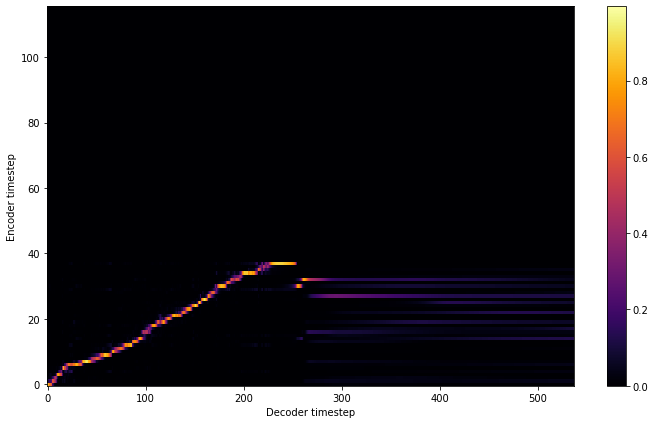

Saving model and optimizer state at iteration 160 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 20 Iteration: 160


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20 Validation loss 168:  0.218313  Time: 0.4m LR: 0.000500


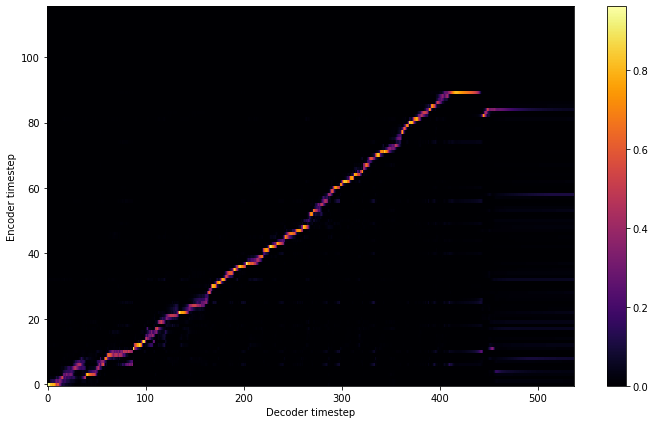

Saving model and optimizer state at iteration 168 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 21 Iteration: 168


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 21 Validation loss 176:  0.212052  Time: 0.4m LR: 0.000500


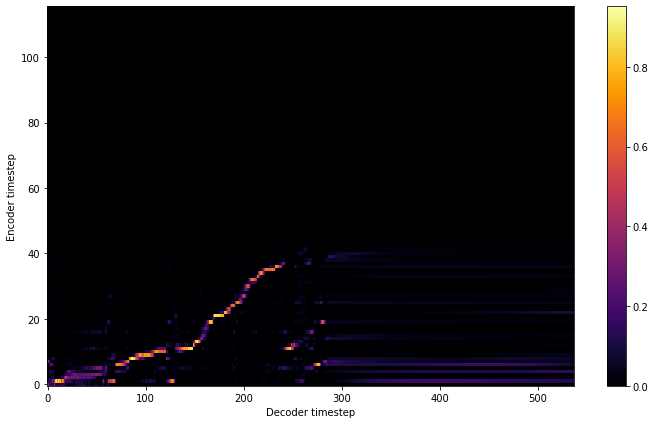

Saving model and optimizer state at iteration 176 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 22 Iteration: 176


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 22 Validation loss 184:  0.210758  Time: 0.4m LR: 0.000500


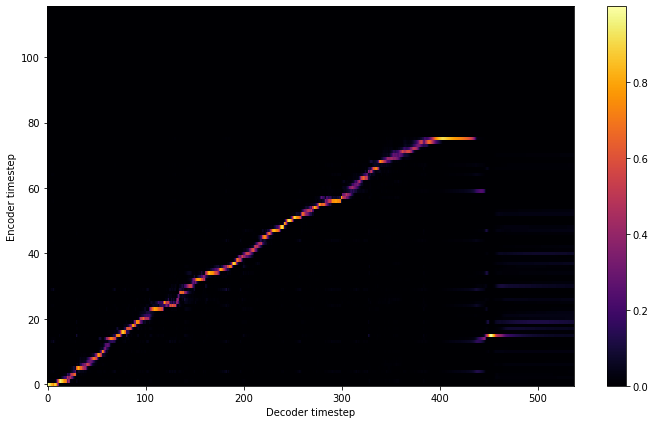

Saving model and optimizer state at iteration 184 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 23 Iteration: 184


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 23 Validation loss 192:  0.217623  Time: 0.4m LR: 0.000500


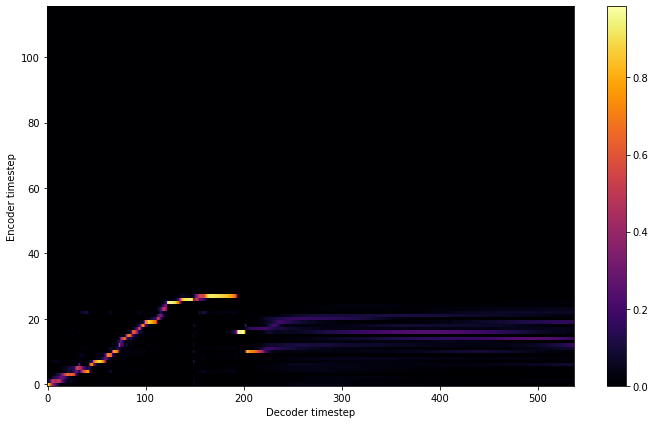

Saving model and optimizer state at iteration 192 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 24 Iteration: 192


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 24 Validation loss 200:  0.213826  Time: 0.4m LR: 0.000500


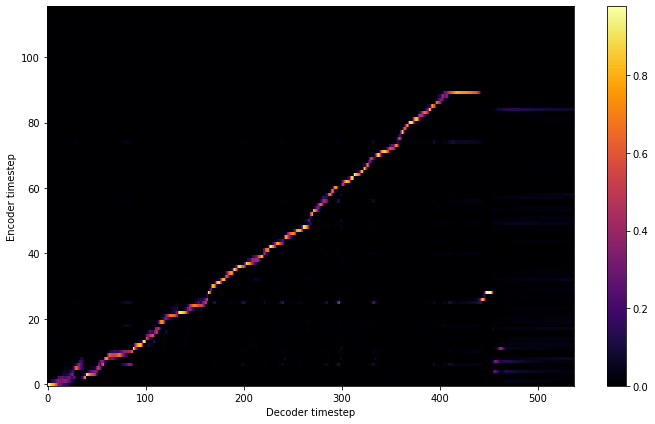

Saving model and optimizer state at iteration 200 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 25 Iteration: 200


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 25 Validation loss 208:  0.209509  Time: 0.4m LR: 0.000500


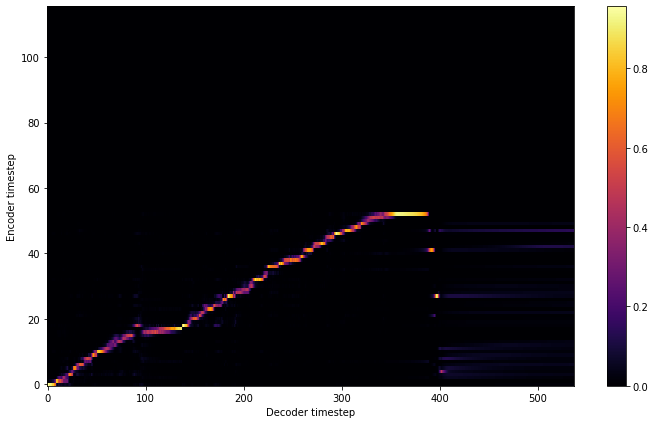

Saving model and optimizer state at iteration 208 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 26 Iteration: 208


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 26 Validation loss 216:  0.205196  Time: 0.4m LR: 0.000500


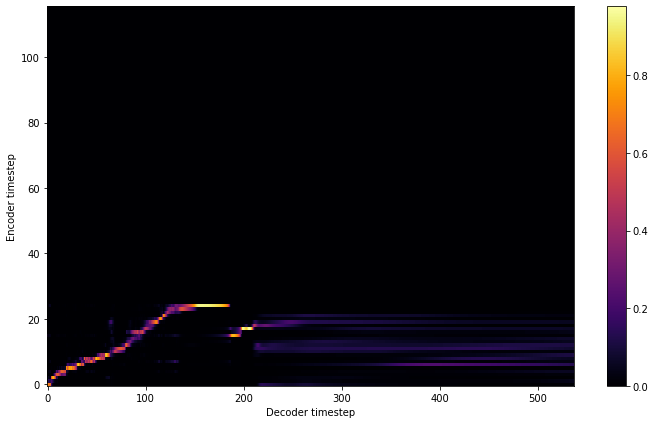

Saving model and optimizer state at iteration 216 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 27 Iteration: 216


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 27 Validation loss 224:  0.202676  Time: 0.4m LR: 0.000500


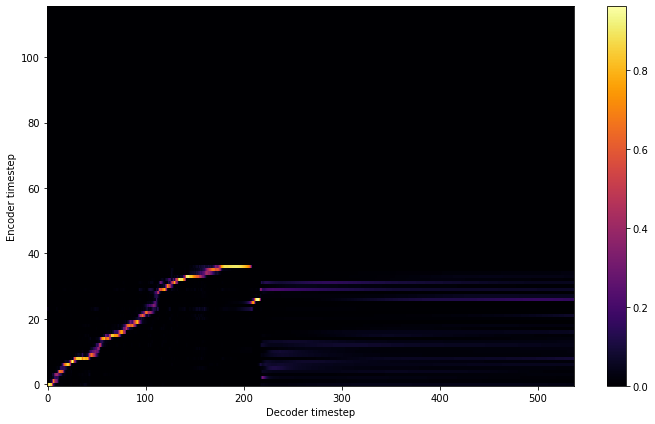

Saving model and optimizer state at iteration 224 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 28 Iteration: 224


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 28 Validation loss 232:  0.200617  Time: 0.4m LR: 0.000500


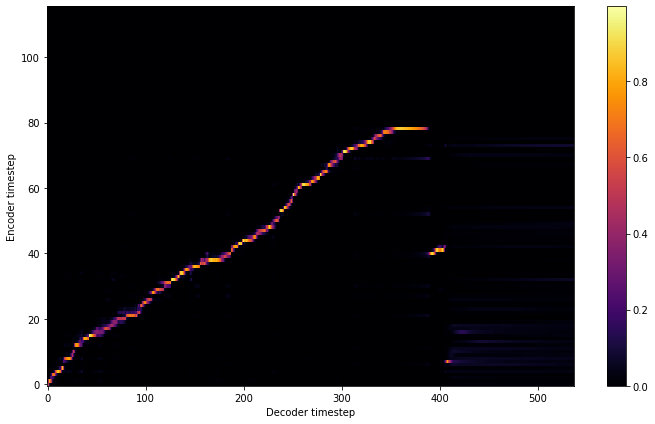

Saving model and optimizer state at iteration 232 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 29 Iteration: 232


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 29 Validation loss 240:  0.197582  Time: 0.4m LR: 0.000500


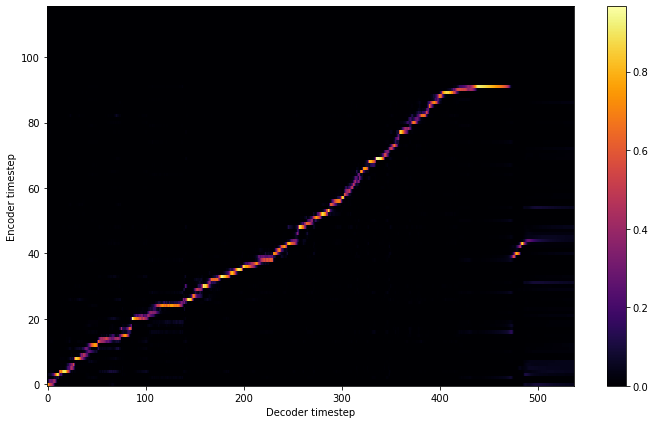

Saving model and optimizer state at iteration 240 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 30 Iteration: 240


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 30 Validation loss 248:  0.195162  Time: 0.4m LR: 0.000500


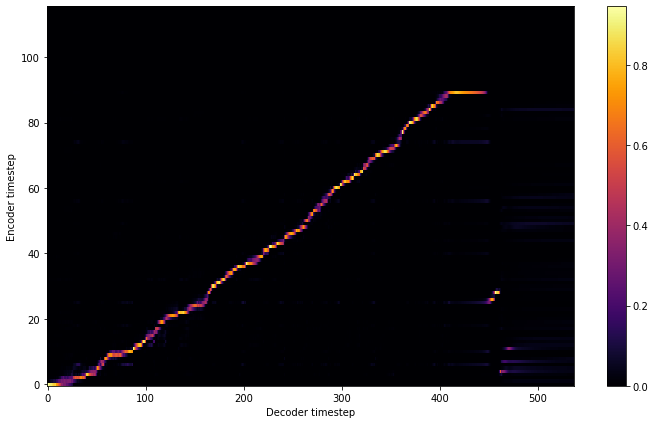

Saving model and optimizer state at iteration 248 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 31 Iteration: 248


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 31 Validation loss 256:  0.194469  Time: 0.4m LR: 0.000500


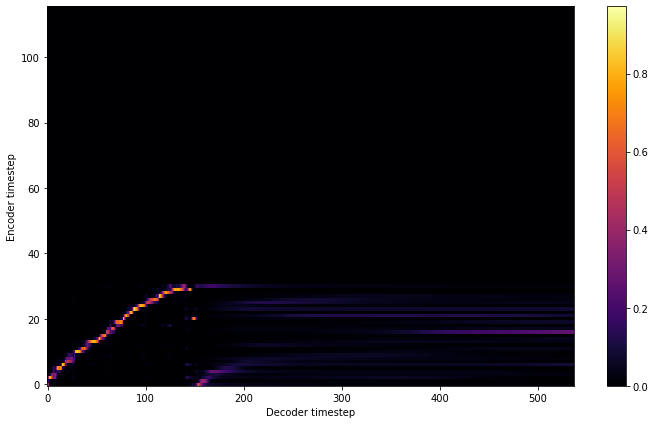

Saving model and optimizer state at iteration 256 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 32 Iteration: 256


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 32 Validation loss 264:  0.192787  Time: 0.4m LR: 0.000500


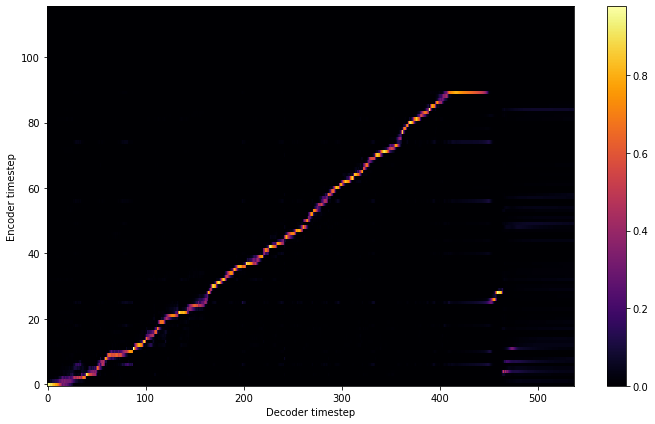

Saving model and optimizer state at iteration 264 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 33 Iteration: 264


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 33 Validation loss 272:  0.190269  Time: 0.4m LR: 0.000500


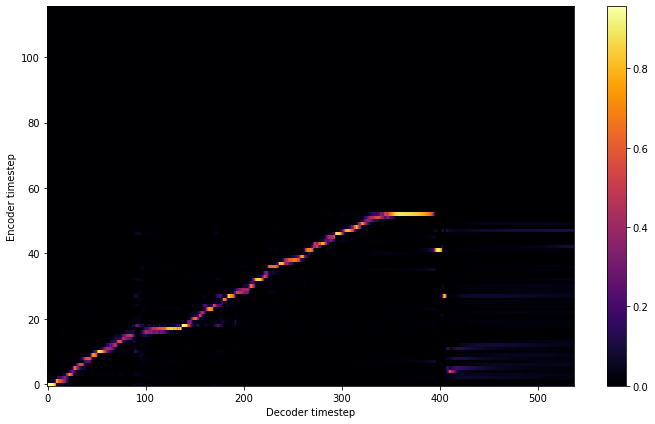

Saving model and optimizer state at iteration 272 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 34 Iteration: 272


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 34 Validation loss 280:  0.189937  Time: 0.4m LR: 0.000500


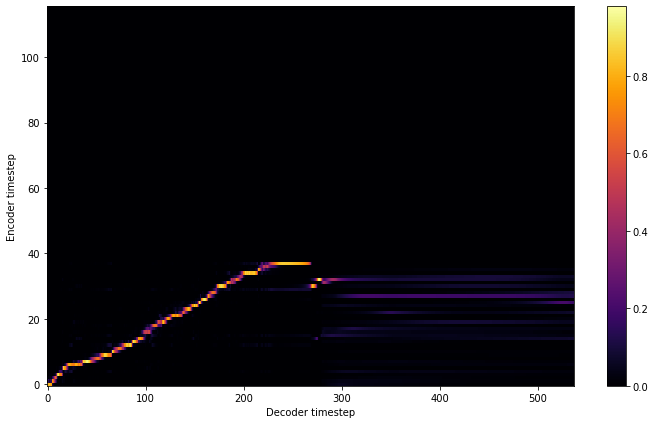

Saving model and optimizer state at iteration 280 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 35 Iteration: 280


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 35 Validation loss 288:  0.188894  Time: 0.4m LR: 0.000500


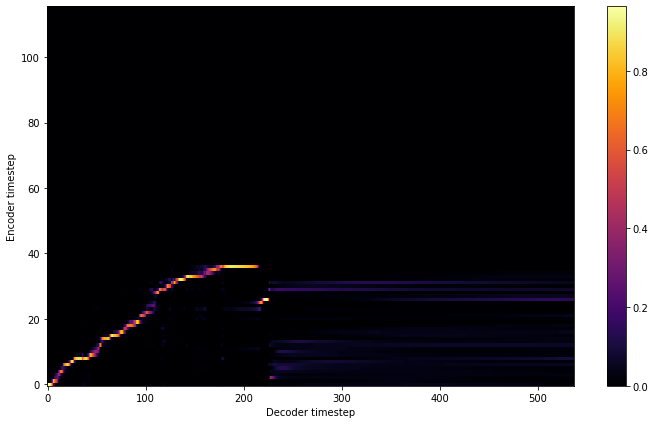

Saving model and optimizer state at iteration 288 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 36 Iteration: 288


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 36 Validation loss 296:  0.187228  Time: 0.4m LR: 0.000500


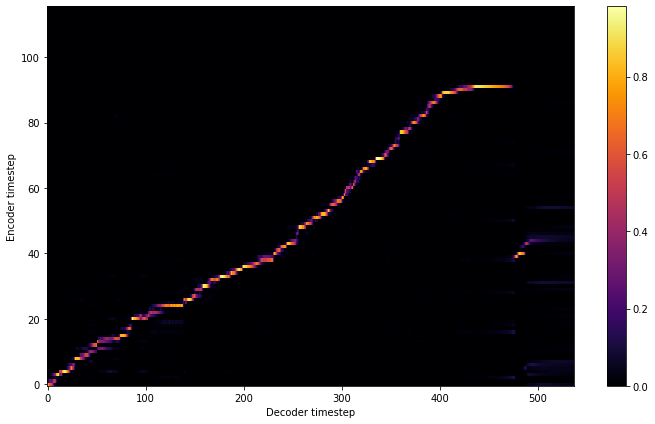

Saving model and optimizer state at iteration 296 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 37 Iteration: 296


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 37 Validation loss 304:  0.187523  Time: 0.4m LR: 0.000500


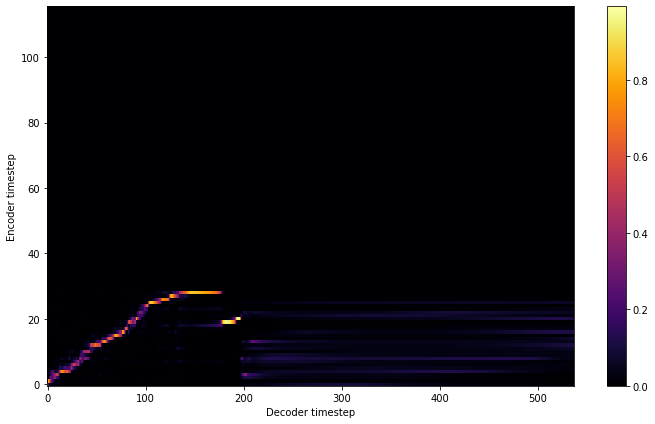

Saving model and optimizer state at iteration 304 to /home/Ciro/Desktop/sansone-english-finetuning/tacotron2/outputDirectory/sansone_en_final
Model Saved

Starting Epoch: 38 Iteration: 304


  0%|          | 0/8 [00:00<?, ?it/s]

In [22]:
print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path,
      warm_start, n_gpus, rank, group_name, hparams, log_directory2)

In [21]:
ls

Dockerfile            inference.ipynb     plotting_utils.py
LICENSE               inference.py        requirements.txt
README.md*            layers.py           stft.py
__pycache__/          logger.py           tacotron2_statedict.pt
audio.wav             loss_function.py    tensorboard.png
audio_processing.py   loss_scaler.py      text/
data_utils.py         model.py            train.py
distributed.py        multiproc.py        utils.py
filelists/            outdir/             waveglow/
hparams.py            output_dataset_en/  waveglow_256channels.pt
inference-test.ipynb  outputdir/          wavs/


Congrats! You've (hopefully) successfully trained a Tacotron model!

If there was a problem with training, just leave a comment on the YouTube video, and I'll try to respond!

Now, before you go into the synthesis notebook, go to your Google Drive, (https://drive.google.com/drive/my-drive), go into the folder that says "colab", go into "outdir", and right click on the .tar file with your model's name.
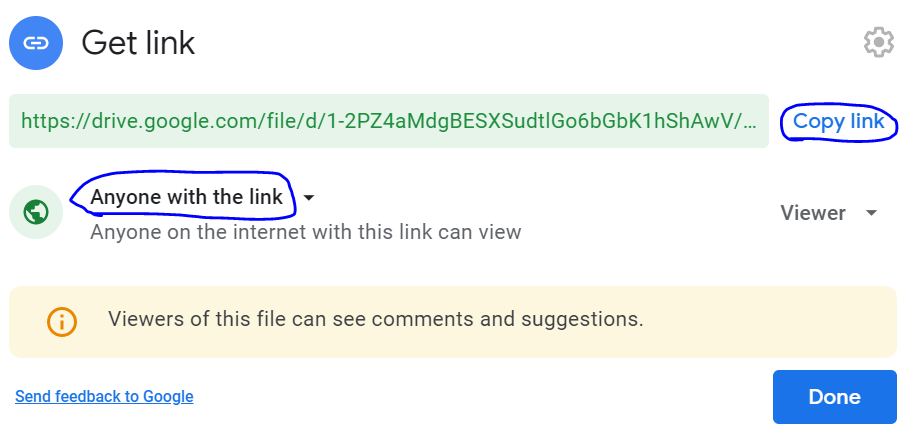
Click on "get shareable link", change "Restricted" to "anyone with the link", then copy the link!